In [45]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from sklearn.preprocessing import MinMaxScaler

### Raw Data

Time period: 2012/08/27 ~ 2018/02/27 (1352 trading days)

In [46]:
df = pd.read_csv('TSE_letgo.csv')
df.head()

,Date,Open,High,Low,Close,Upper,Lower,RSI,TOYC,TOYCChange,...,Thigh,Tlow,Tclose,Tclosechange,TTOYC,TTOYCChange,TYCChange,Tvolume,Tmoney,PE
0,2012/8/27,7504.45,7523.54,7457.75,7468.22,19.09,10.47,0.500900,26.92,0.003600,...,83.5,82.4,83.0,NaN,0.9,0.010976,-0.008464,25735,2135558,16.37
1,2012/8/28,7440.56,7445.08,7359.83,7361.94,4.52,2.11,0.352353,-27.66,-0.003704,...,83.4,82.0,82.4,-0.007229,-0.7,-0.008434,0.012195,32429,2674091,16.25
2,2012/8/29,7379.48,7405.30,7368.40,7391.15,14.15,11.08,0.197637,17.54,0.002383,...,83.0,82.1,82.7,0.003641,0.2,0.002427,-0.007200,18468,1527787,15.60
3,2012/8/30,7372.06,7404.94,7360.10,7371.44,32.88,11.34,0.188303,-19.09,-0.002583,...,83.2,82.3,82.7,0.000000,-0.4,-0.004837,0.003600,46032,3815781,15.60
4,2012/8/31,7363.25,7406.52,7363.25,7397.06,9.46,0.00,0.251779,-8.19,-0.001111,...,83.3,82.4,83.3,0.007255,-0.3,-0.003628,0.000000,13536,1125345,15.72


In [47]:
MACD = df.MACD[0:-1]
OSC = df.OSC[0:-1]
KD = df.K[0:-1] - df.D[0:-1]
HL = df.Thigh[0:-1] - df.Tlow[0:-1]
C = df.Close[0:-1]
SMA = df.SMA5[0:-1] - df.SMA20[0:-1]
MA = df.MA5[0:-1] - df.MA10[0:-1]
UW = df.Upper[0:-1]
LW = df.Lower[0:-1]
RSI = df.RSI[0:-1]
OBV = df.OBV[0:-1]
VolumeChange = df.VolumeChange[0:-1]
df = df.drop([0]) # since there are NaN in the first row
df = df.reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Upper,Lower,RSI,TOYC,TOYCChange,...,Thigh,Tlow,Tclose,Tclosechange,TTOYC,TTOYCChange,TYCChange,Tvolume,Tmoney,PE
0,2012/8/28,7440.56,7445.08,7359.83,7361.94,4.52,2.11,0.352353,-27.66,-0.003704,...,83.4,82.0,82.4,-0.007229,-0.7,-0.008434,0.012195,32429,2674091,16.25
1,2012/8/29,7379.48,7405.30,7368.40,7391.15,14.15,11.08,0.197637,17.54,0.002383,...,83.0,82.1,82.7,0.003641,0.2,0.002427,-0.007200,18468,1527787,15.60
2,2012/8/30,7372.06,7404.94,7360.10,7371.44,32.88,11.34,0.188303,-19.09,-0.002583,...,83.2,82.3,82.7,0.000000,-0.4,-0.004837,0.003600,46032,3815781,15.60
3,2012/8/31,7363.25,7406.52,7363.25,7397.06,9.46,0.00,0.251779,-8.19,-0.001111,...,83.3,82.4,83.3,0.007255,-0.3,-0.003628,0.000000,13536,1125345,15.72
4,2012/9/3,7430.40,7462.15,7389.68,7450.53,11.62,40.72,0.444581,33.34,0.004507,...,83.9,82.8,83.9,0.007203,0.2,0.002401,0.007300,20796,1738755,15.83


In [48]:
df.shape

(1352, 37)

### Input and Output Variables

X: Selected technical indicators (Inputs)

In [49]:
X = pd.concat([df.Open, df.TOYCChange, df.TTOYCChange, df.TYCChange, MA, KD, OSC], axis=1)
X.shape

(1352, 7)

In [50]:
X.head()

,Open,TOYCChange,TTOYCChange,TYCChange,0,1,OSC
0,7440.56,-0.003704,-0.008434,0.012195,-19.38,-0.1113,3.94
1,7379.48,0.002383,0.002427,-0.007200,-21.61,-0.1989,-5.57
2,7372.06,-0.002583,-0.004837,0.003600,-8.58,-0.1789,-11.45
3,7363.25,-0.001111,-0.003628,0.000000,7.75,-0.1750,-15.93
4,7430.40,0.004507,0.002401,0.007300,-8.65,-0.1216,-17.59


In [51]:
data1 = X.values
data1.shape

(1352, 7)

Y: Change of close price (Outputs)

In [52]:
Y = df.CloseChange
data2 = Y.values.reshape(-1, 1)
data2.shape

(1352, 1)

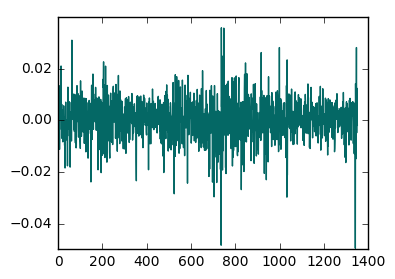

In [53]:
plt.figure(figsize=(4, 3))
plt.plot(Y.values, c='#046865')

### Hyperparameter

In [54]:
learning_rate = 0.001
#learning_rate = tf.train.exponential_decay(0.3, 1, 1, 0.99, staircase=True)
total_epoch = 1000
train_size = 0.6
val_size = 0.2
look_back = 6
n_step = look_back
n_input = X.shape[1]
n_output = 1
keep_prob = 0.8
#n_hidden1 = 10
#n_hidden2 = 20
#n_hidden3 = 16
n_hidden1 = n_step*n_input*2
n_hidden2 = n_step*n_input*4
beta = 0.01

### Custom Function

In [55]:
def create_timeseries(data1, data2, look_back=1):
    x_data = []
    for i in range(len(data1)-look_back+1):
        a = data1[i:(i+look_back), :]
        x_data.append(a) 
    y_data = data2[look_back-1:]
    return np.array(x_data), np.array(y_data)

In [56]:
def layer(input_dim, output_dim, inputs, activation=None):
    w_init = tf.variance_scaling_initializer(mode='fan_avg', distribution='uniform', scale=0.12)
    b_init = tf.constant_initializer(0.01)
    w = tf.Variable(w_init([input_dim, output_dim]))
    #w = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1) / np.sqrt(input_dim/2))
    b = tf.Variable(b_init([output_dim]))
    xwb = tf.add(tf.matmul(inputs, w), b)
    if activation is None:
        outputs = xwb
    else:
        outputs = activation(xwb)
    return outputs

In [57]:
def train_test_split(x_data, y_data, train_size=train_size, val_size=val_size):
    x_train = x_data[0:int(len(x_data)*train_size), :]
    x_val = x_data[int(len(x_data)*train_size):int(len(x_data)*(train_size+val_size))]
    x_test = x_data[int(len(x_data)*(train_size+val_size)):len(x_data), :] 
    y_train = y_data[0:int(len(y_data)*train_size), :]
    y_val = y_data[int(len(y_data)*train_size):int(len(y_data)*(train_size+val_size))]
    y_test = y_data[int(len(y_data)*(train_size+val_size)):len(y_data), :] 
    return x_train, x_val, x_test, y_train, y_val, y_test

In [58]:
def data_movement(pred, true):
    move_pred = list(pred)
    move_pred = np.array(move_pred)
    move_pred[move_pred>0] = 1
    move_pred[move_pred<0] = 0
    move_true = list(true)
    move_true = np.array(move_true)
    move_true[move_true>0] = 1
    move_true[move_true<0] = 0
    acc = np.sum(move_pred == move_true) / len(move_pred) 
    return move_pred, move_true, acc

### Training & Testing Sets

In [59]:
x_data, y_data = create_timeseries(data1, data2, look_back)

In [60]:
x_data.shape, y_data.shape

((1347, 6, 7), (1347, 1))

In [61]:
x_data

array([[[ 7.4405600e+03, -3.7036940e-03, -8.4337350e-03, ...,
         -1.9380000e+01, -1.1130000e-01,  3.9400000e+00],
        [ 7.3794800e+03,  2.3825240e-03,  2.4271840e-03, ...,
         -2.1610000e+01, -1.9890000e-01, -5.5700000e+00],
        [ 7.3720600e+03, -2.5828190e-03, -4.8367590e-03, ...,
         -8.5800000e+00, -1.7890000e-01, -1.1450000e+01],
        [ 7.3632500e+03, -1.1110450e-03, -3.6275700e-03, ...,
          7.7500000e+00, -1.7500000e-01, -1.5930000e+01],
        [ 7.4304000e+03,  4.5071960e-03,  2.4009600e-03, ...,
         -8.6500000e+00, -1.2160000e-01, -1.7590000e+01],
        [ 7.4713100e+03,  2.7890630e-03,  1.1918950e-03, ...,
         -2.7500000e+00, -8.1000000e-03, -1.5240000e+01]],

       [[ 7.3794800e+03,  2.3825240e-03,  2.4271840e-03, ...,
         -2.1610000e+01, -1.9890000e-01, -5.5700000e+00],
        [ 7.3720600e+03, -2.5828190e-03, -4.8367590e-03, ...,
         -8.5800000e+00, -1.7890000e-01, -1.1450000e+01],
        [ 7.3632500e+03, -1.1110450e-0

In [62]:
y_data

array([[ 0.00011006],
       [-0.01126105],
       [-0.00552702],
       ...,
       [ 0.01239592],
       [ 0.00390475],
       [-0.00195908]])

In [63]:
x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(x_data, y_data)

In [64]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((808, 6, 7), (808, 1), (269, 6, 7), (269, 1), (270, 6, 7), (270, 1))

In [65]:
x_train = x_train.reshape(-1, n_step*n_input)
x_val = x_val.reshape(-1, n_step*n_input)
x_test = x_test.reshape(-1, n_step*n_input)

In [66]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((808, 42), (808, 1), (269, 42), (269, 1), (270, 42), (270, 1))

### Normalization

In [67]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

### Input Layer

In [68]:
x = tf.placeholder('float', [None, n_step*n_input])

In [69]:
x

<tf.Tensor 'Placeholder_2:0' shape=(?, 42) dtype=float32>

### Hidden Layer

In [70]:
h1 = layer(n_step*n_input, n_hidden1, x, tf.nn.tanh)
#h1 = tf.nn.dropout(h1, keep_prob=keep_prob)

In [71]:
h1

<tf.Tensor 'Tanh_2:0' shape=(?, 84) dtype=float32>

In [72]:
h2 = layer(n_hidden1, n_hidden2, h1, tf.nn.tanh)
#h2 = tf.nn.dropout(h2, keep_prob=keep_prob)

In [73]:
h2

<tf.Tensor 'Tanh_3:0' shape=(?, 168) dtype=float32>

In [74]:
#h3 = layer(n_hidden2, n_hidden3, h2, tf.nn.relu)
#h3 = tf.nn.dropout(h3, keep_prob=keep_prob)

In [75]:
#h3

### Output Layer

In [76]:
#y_pred = layer(n_hidden1, n_output, h1, tf.nn.tanh)
y_pred = layer(n_hidden2, n_output, h2)
#y_pred = layer(n_hidden3, n_output, h3)

In [77]:
y_pred

<tf.Tensor 'Add_5:0' shape=(?, 1) dtype=float32>

### Modeling

In [78]:
y = tf.placeholder('float', [None, n_output])
#loss_function = tf.reduce_mean(tf.abs(y_pred-y))
loss_function = tf.reduce_mean(tf.squared_difference(y_pred, y))
#optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.0, epsilon=1e-10).minimize(loss_function)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_function)
w_init = tf.variance_scaling_initializer(mode='fan_avg', distribution='uniform', scale=0.12)
w = tf.Variable(w_init([n_input, n_output]))
regularizer = tf.nn.l2_loss(w)
loss_function = tf.reduce_mean(loss_function + beta*regularizer)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=1e-08).minimize(loss_function)

### Training

In [79]:
batch_size = 130
total_batch = int(len(y_train)//batch_size)

In [80]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_epoch = []; train_loss = []; val_loss=[]; test_loss = []; train_acc = []; val_acc = []; test_acc = [];

In [81]:
start = time()

for epoch in range(total_epoch):
    shuffle = np.random.permutation(len(y_train))
    x_train = x_train[shuffle]
    y_train = y_train[shuffle]
    for i in range(total_batch):
        k = i * batch_size
        batch_x = x_train[k : k+batch_size]
        batch_y = y_train[k : k+batch_size]
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    
    #sess.run(optimizer, feed_dict={x: x_train, y: y_train})
    loss1 = sess.run(loss_function, feed_dict={x: x_train, y: y_train})
    loss2 = sess.run(loss_function, feed_dict={x: x_val, y: y_val})
    loss3 = sess.run(loss_function, feed_dict={x: x_test, y: y_test})
    train_epoch.append(epoch); train_loss.append(loss1); val_loss.append(loss2); test_loss.append(loss3);
    
    train_pred = sess.run(y_pred, feed_dict={x: x_train})
    val_pred = sess.run(y_pred, feed_dict={x: x_val})
    test_pred = sess.run(y_pred, feed_dict={x: x_test})
    #train_pred = scaler.inverse_transform(train_pred)
    #val_pred = scaler.inverse_transform(val_pred)
    #test_pred = scaler.inverse_transform(test_pred)
    train_pred = train_pred.reshape(-1, 1)
    val_pred = val_pred.reshape(-1, 1)
    test_pred = test_pred.reshape(-1, 1)
    pred_result = np.concatenate((train_pred, val_pred, test_pred), axis=0)
    true_result = np.concatenate((y_train, y_val, y_test), axis=0)
    
    move_pred_train, move_true_train, acc1 = data_movement(train_pred, y_train)
    move_pred_val, move_true_val, acc2 = data_movement(val_pred, y_val)
    move_pred_test, move_true_test, acc3 = data_movement(test_pred, y_test)
    train_acc.append(acc1); val_acc.append(acc2); test_acc.append(acc3);


-------------------------

Train Acc= 0.7252475247524752
Val Acc= 0.6431226765799256
Test Acc= 0.7444444444444445
Train Loss= 4.0537314e-05
Val Loss= 4.6422665e-05
Test Loss= 2.3128232e-05
Today Prediction= [1.]
Run Time= 23.23183846473694


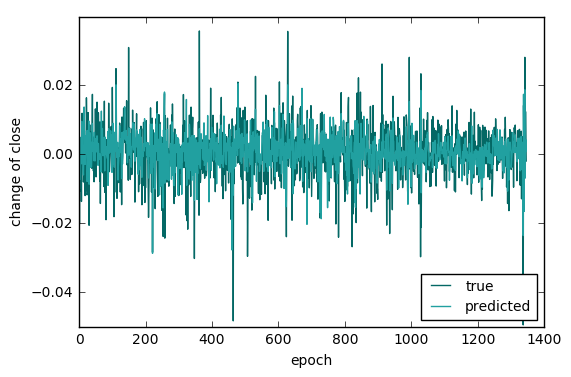

In [82]:
plt.plot(true_result[:, 0], c='#046865', label='true')
plt.plot(pred_result[:, 0], c='#21A0A0', label='predicted')
plt.xlabel('epoch')
plt.ylabel('change of close')
plt.legend(loc='lower right', prop={'size': 10})

#print ('Pred Result=\n', train_pred)
#print ('True Result=\n', y_train)
#print ('Move Pred=', move_pred_train[:, 0])
#print ('Move True=', move_true_train[:, 0])
print ('\n-------------------------\n')
print ('Train Acc=', train_acc[-1])
print ('Val Acc=', val_acc[-1])
print ('Test Acc=', test_acc[-1])
print ('Train Loss=', train_loss[-1])
print ('Val Loss=', val_loss[-1])
print ('Test Loss=', test_loss[-1])
print ('Today Prediction=', move_pred_test[-1])

end = time()
print ('Run Time=', end-start)

sess.close()

In [83]:
move_pred_train.shape, move_true_train.shape, move_pred_val.shape, move_true_val.shape, move_pred_test.shape, move_true_test.shape

((808, 1), (808, 1), (269, 1), (269, 1), (270, 1), (270, 1))

### Loss & Accuracy

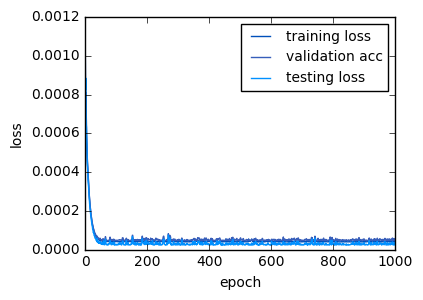

In [84]:
%matplotlib inline
gcf = plt.gcf()
gcf.set_size_inches(4, 3)
plt.plot(train_epoch, train_loss, c='#0050BA', label='training loss')
plt.plot(train_epoch, val_loss, c='#375EBA', label='validation acc')
plt.plot(train_epoch, test_loss, c='#0090FF', label='testing loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right', prop={'size': 10})

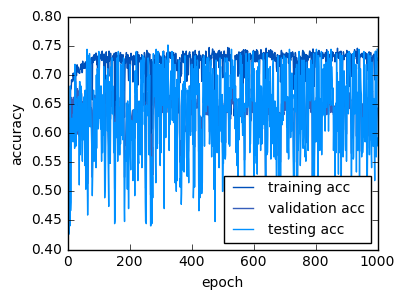

In [85]:
%matplotlib inline
gcf = plt.gcf()
gcf.set_size_inches(4, 3)
plt.plot(train_epoch, train_acc, c='#0050BA', label='training acc')
plt.plot(train_epoch, val_acc, c='#375EBA', label='validation acc')
plt.plot(train_epoch, test_acc, c='#0090FF', label='testing acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right', prop={'size': 10})

Accuracy should be at least greater than the following:

In [86]:
len(move_true_train[move_true_train>0]) / len(move_true_train)

0.525990099009901

In [87]:
len(move_true_val[move_true_val>0]) / len(move_true_val)

0.5762081784386617

In [88]:
len(move_true_test[move_true_test>0]) / len(move_true_test)

0.5740740740740741